In [1]:
import numpy as np
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
import datetime
import random

D:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# load the dataset and normalize
data_file = open('youtube_small_seq10.pkl', 'rb')
train_data, train_labels, test_data, test_labels = pickle.load(data_file, encoding='latin1')
data_file.close()

train_data = train_data.astype(np.float32)
test_data = test_data.astype(np.float32)
train_labels = train_labels.astype(np.float32)
test_labels = test_labels.astype(np.float32)

#train_data = (train_data - np.mean(train_data, axis=(2, 3, 4), keepdims=True)) / np.std(train_data, axis=(2, 3, 4), keepdims=True)
#test_data = (test_data - np.mean(test_data, axis=(2, 3, 4), keepdims=True)) / np.std(test_data, axis=(2, 3, 4), keepdims=True)
print(train_data.shape, train_data.dtype)
print(train_labels.shape, train_labels.dtype)
print(np.max(test_data), np.min(test_data))
#print(test_labels[0:20])

(8000, 10, 64, 64, 3) float32
(8000, 10, 7, 2) float32
255.0 0.0


In [3]:
def weight_init(shape):
    initial = tf.truncated_normal(shape, stddev=0.01) / 10
    #return tf.get_variable(name='weights', shape=shape, initializer=tf.contrib.layers.xavier_initializer())
    return tf.Variable(initial)


def bias_init(shape):
    initial = tf.constant(0.0001, shape=shape)
    return tf.Variable(initial)


def conv2d(x, w):
    return tf.nn.conv2d(x, w, strides=[1, 1, 1, 1], padding='SAME')


def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

def max_pool_3x3(x):
    return tf.nn.max_pool(x, ksize=[1, 3, 3, 1], strides=[1, 3, 3, 1], padding='SAME')

In [4]:
hm_train_data, seq_len, dim, _, im_dep = train_data.shape
hm_test_data = test_data.shape[0]
train_loss = np.zeros((0, 1))
test_loss = np.zeros((0, 1))

In [5]:
# Hyperparemeters, configurations
eval_int = 600
dep1 = 32
dep2 = 64
dep3 = 128
dep4 = 256
fc_len = int(4 * 4 * dep4)
max_epoch = 5
batch_size = 5
#hm_hid_node = 200
hm_cell = 512

In [6]:
sequence_placeholder = tf.placeholder(dtype=tf.float32, shape=[batch_size, seq_len, 64, 64, 3])
label_placeholder = tf.placeholder(dtype=tf.float32, shape=[batch_size, seq_len, 7, 2])

In [7]:
# Define weights for the convolutional layer
w_conv1 = weight_init(shape=[5, 5, 3, dep1])
b_conv1 = bias_init(shape=[64, 64, dep1])

w_conv2 = weight_init(shape=[5, 5, dep1, dep2])
b_conv2 = bias_init(shape=[32, 32, dep2])

w_conv3 = weight_init(shape=[5, 5, dep2, dep3])
b_conv3 = bias_init(shape=[16, 16, dep3])

w_conv4 = weight_init(shape=[5, 5, dep3, dep4])
b_conv4 = bias_init(shape=[8, 8, dep4])


w_fc = weight_init(shape=[hm_cell, 14])
b_fc = bias_init(shape=[14])

# for each time step, do the convolution and pooling
rnn_input = tf.zeros(shape=[batch_size, 0, fc_len])
for i in np.arange(seq_len):
    temp = tf.reshape(sequence_placeholder[:, i, :, :, :], [-1, 64, 64, 3])
    h_conv1 = tf.nn.relu(conv2d(temp, w_conv1) + b_conv1)
    h_pool1 = max_pool_2x2(h_conv1) # 32 * 32
    
    h_conv2 = tf.nn.relu(conv2d(h_pool1, w_conv2) + b_conv2)
    h_pool2 = max_pool_2x2(h_conv2) # 16 * 16
    
    h_conv3 = tf.nn.relu(conv2d(h_pool2, w_conv3) + b_conv3)
    h_pool3 = max_pool_2x2(h_conv3) # 8 * 8
    
    h_conv4 = tf.nn.relu(conv2d(h_pool3, w_conv4) + b_conv4)
    h_pool4 = max_pool_2x2(h_conv4) # 4 * 4
    
    fc1 = tf.reshape(h_pool4, [-1, 1, fc_len])
    
    
    rnn_input = tf.concat([rnn_input, fc1], axis=1)
    
print(rnn_input.shape)

(5, 10, 4096)


In [8]:
lstm_cell = tf.nn.rnn_cell.LSTMCell(hm_cell)
h_val, _ = tf.nn.dynamic_rnn(lstm_cell, rnn_input, dtype=tf.float32)
print(h_val.get_shape().as_list())

[5, 10, 512]


In [9]:
# for each time step, do the output layer
relevant_output = tf.zeros(shape=[batch_size, 0, 14])
for i in np.arange(seq_len):
    temp = tf.reshape(h_val[:, i, :], [batch_size, hm_cell])
    output = tf.matmul(temp, w_fc) + b_fc
    #print(output.shape)
    output = tf.reshape(output, [-1, 1, 14])
    #print(output.shape)
    relevant_output = tf.concat([relevant_output, output], axis=1)
    
print(relevant_output.shape)

(5, 10, 14)


In [10]:
relevant_output = tf.reshape(relevant_output, [-1, 10, 7, 2])
print(relevant_output.get_shape().as_list())

[5, 10, 7, 2]


In [11]:
#msl = tf.losses.mean_squared_error(labels=label_placeholder, predictions=relevant_output)
#print(msl.get_shape().as_list())
#mean_loss = tf.reduce_mean(tf.sqrt(msl))
#print(mean_loss.get_shape().as_list())

mean_dist_loss = tf.reduce_mean(tf.sqrt(tf.reduce_sum((label_placeholder - relevant_output) ** 2, axis=3)))
print(mean_dist_loss.get_shape().as_list())

train_step = tf.train.AdamOptimizer(learning_rate=0.001).minimize(mean_dist_loss)

[]


In [12]:
# start training and evaluate accuracy, plot intermediate results
# with tf.Session() as sess:

sess = tf.Session()
sess.run(tf.global_variables_initializer())

for epoch in np.arange(max_epoch):
    start = datetime.datetime.now()
    re_order = np.random.permutation(hm_train_data)
    

    for i in np.arange(int(hm_train_data / batch_size)):
        batch_x = train_data[re_order[i * batch_size:(i + 1) * batch_size], :, :, :, :]
        batch_y = train_labels[re_order[i * batch_size:(i + 1) * batch_size], :, :, :]
        batch_x = (batch_x - np.mean(batch_x, axis=(2, 3, 4), keepdims=True)) / np.std(batch_x, axis=(2, 3, 4), keepdims=True)

        msl_tr = sess.run(mean_dist_loss, feed_dict={sequence_placeholder: batch_x, label_placeholder:batch_y})
        train_loss = np.vstack((train_loss, msl_tr))

        # evaluate the training performance
        if i % eval_int == 0:
            msl_te = 0
            for j in np.arange(int(hm_test_data / batch_size)):
                b_x = test_data[j * batch_size:(j + 1) * batch_size, :, :, :, :]
                b_y = test_labels[j * batch_size:(j + 1) * batch_size, :, :, :]
                b_x = (b_x - np.mean(b_x, axis=(2, 3, 4), keepdims=True)) / np.std(b_x, axis=(2, 3, 4), keepdims=True)
                msl_te += sess.run(mean_dist_loss, feed_dict={sequence_placeholder: b_x, label_placeholder: b_y})
                    
            loss = msl_te / (hm_test_data / batch_size)
            test_loss = np.vstack((test_loss, loss))
            print("Epoch: %d step: %d, train loss: %g, test loss: %g" %
                            (epoch, i, np.mean(train_loss[-int(hm_train_data / batch_size):]), loss))

        sess.run(train_step, feed_dict={sequence_placeholder: batch_x, label_placeholder: batch_y})

    dur = datetime.datetime.now() - start
    print('Epoch', epoch, 'training done, runtime', dur)

        
msl_te = 0
for j in np.arange(int(hm_test_data / batch_size)):
    b_x = test_data[j * batch_size:(j + 1) * batch_size, :, :, :, :]
    b_y = test_labels[j * batch_size:(j + 1) * batch_size, :, :, :]
    b_x = (b_x - np.mean(b_x, axis=(2, 3, 4), keepdims=True)) / np.std(b_x, axis=(2, 3, 4), keepdims=True)
    msl_te += sess.run(mean_dist_loss, feed_dict={sequence_placeholder: b_x, label_placeholder: b_y})
        
loss = msl_te / (hm_test_data / batch_size)
    
print("Training finished! Final training error: %g, testing error: %g" %
                (np.mean(train_loss[-int(hm_train_data / batch_size):]), loss))

test_loss = np.vstack((test_loss, loss))

Epoch: 0 step: 0, train loss: 44.8121, test loss: 47.6072
Epoch: 0 step: 600, train loss: 11.3423, test loss: 10.9716
Epoch: 0 step: 1200, train loss: 10.3847, test loss: 10.9624
Epoch 0 training done, runtime 0:04:14.254047
Epoch: 1 step: 0, train loss: 10.1323, test loss: 11.1612
Epoch: 1 step: 600, train loss: 9.44618, test loss: 10.914
Epoch: 1 step: 1200, train loss: 9.41661, test loss: 10.965
Epoch 1 training done, runtime 0:04:04.176320
Epoch: 2 step: 0, train loss: 9.42382, test loss: 10.8058
Epoch: 2 step: 600, train loss: 9.39478, test loss: 10.7536
Epoch: 2 step: 1200, train loss: 9.43024, test loss: 10.4644
Epoch 2 training done, runtime 0:04:06.465437
Epoch: 3 step: 0, train loss: 9.42286, test loss: 10.516
Epoch: 3 step: 600, train loss: 9.45042, test loss: 10.5519
Epoch: 3 step: 1200, train loss: 9.4117, test loss: 10.943
Epoch 3 training done, runtime 0:04:03.017974
Epoch: 4 step: 0, train loss: 9.41164, test loss: 10.4977
Epoch: 4 step: 600, train loss: 9.39709, test l

In [13]:
prediction = np.zeros((0, 7, 2))
pixel_err = np.zeros((0, 1))

for j in np.arange(int(hm_test_data / batch_size)):
    ba_x = test_data[j * batch_size:(j + 1) * batch_size, :, :, :, :]
    ba_x = (ba_x - np.mean(ba_x, axis=(2, 3, 4), keepdims=True)) / np.std(ba_x, axis=(2, 3, 4), keepdims=True)
    ba_y = test_labels[j * batch_size:(j + 1) * batch_size, :, :, :]
    re_out = sess.run(relevant_output, feed_dict={sequence_placeholder:ba_x, label_placeholder:ba_y})
    prediction = np.vstack((prediction, np.reshape(re_out, [-1, 7, 2])))
    
print(prediction.shape)
print(prediction[0:40, :, :])

(6000, 7, 2)
[[[24.45240211 12.75425816]
  [20.38471794 26.21397591]
  [28.71182632 27.97433853]
  [18.82071304 26.71871948]
  [30.5746727  27.45056152]
  [20.9539547  18.57926559]
  [28.50983047 18.65826607]]

 [[30.62159729 16.03967476]
  [25.57536888 33.01980209]
  [36.03469849 35.25178909]
  [23.61255264 33.6389389 ]
  [38.38888168 34.5955658 ]
  [26.28520393 23.34856033]
  [35.77281952 23.47730637]]

 [[31.56715965 16.54323196]
  [26.37094498 34.06293488]
  [37.1570816  36.36721039]
  [24.34700775 34.69961548]
  [39.58657455 35.6906929 ]
  [27.10233116 24.07955742]
  [36.88602066 24.21592331]]

 [[31.69742584 16.61260796]
  [26.48054886 34.20664597]
  [37.31171417 36.52088165]
  [24.44818878 34.84573364]
  [39.75157547 35.84156418]
  [27.21490097 24.18026543]
  [37.03938293 24.31768227]]

 [[31.71509743 16.62202072]
  [26.49541664 34.22613907]
  [37.33269501 36.54172516]
  [24.46191597 34.86556244]
  [39.77396393 35.86203384]
  [27.23017693 24.19392586]
  [37.06019592 24.33148766]

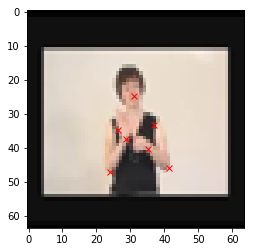

In [14]:
plt.figure(1)
img = test_data[0, 0, :, :, :].reshape(64, 64, 3) / 255.

plt.imshow(img)
l1 = plt.plot(test_labels[0, 0, :, 0], test_labels[0, 0, :, 1], 'rx', label='joint position')
plt.show()

In [15]:
loss_dist = np.sqrt(np.sum((np.reshape(test_labels, [-1, 7, 2]) - prediction) ** 2, axis=2))
pixel_range = np.linspace(0, 20, 200)
print(loss_dist.shape)
acc_joint = np.zeros((200, 7))
for p in np.arange(7):
    error = loss_dist[:, p]
    for i in np.arange(200):
        count = np.sum(error <= pixel_range[i])
        acc_joint[i, p] = count / 6000.0
#print('Done')    

(6000, 7)


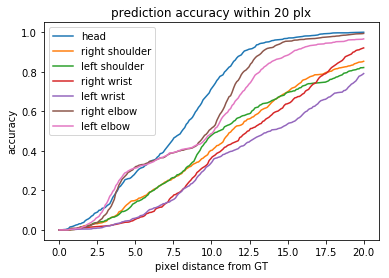

In [16]:
plt.figure(2)
l1 = plt.plot(pixel_range, acc_joint[:, 0], label='head')
l2 = plt.plot(pixel_range, acc_joint[:, 1], label='right shoulder')
l3 = plt.plot(pixel_range, acc_joint[:, 2], label='left shoulder')
l4 = plt.plot(pixel_range, acc_joint[:, 3], label='right wrist')
l5 = plt.plot(pixel_range, acc_joint[:, 4], label='left wrist')
l6 = plt.plot(pixel_range, acc_joint[:, 5], label='right elbow')
l7 = plt.plot(pixel_range, acc_joint[:, 6], label='left elbow')

plt.legend()

plt.title('prediction accuracy within 20 plx')

plt.xlabel('pixel distance from GT')

plt.ylabel('accuracy')

plt.show()